In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import os 
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision.transforms.functional import to_pil_image
import cv2
import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

In [2]:
train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_test_transformer = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [3]:
data_folder = 'data2'
train_path = os.path.join(data_folder, "train")
val_path = os.path.join(data_folder, "test")
test_path = os.path.join(data_folder, "val")
batch_size = 4

train_ds = torchvision.datasets.ImageFolder(train_path, train_transformer)
val_ds = torchvision.datasets.ImageFolder(val_path, val_test_transformer)
test_ds = torchvision.datasets.ImageFolder(test_path, val_test_transformer)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

class_names = train_ds.classes
print(class_names)

['benign', 'malignant']


1977
0


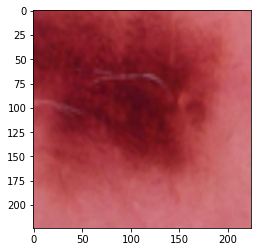

In [4]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

img, label = train_ds[0]
img = denormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
print(len(train_ds))
print(label)
plt.imshow(img)

In [5]:
def get_model(outputs=2):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, outputs)
    return model

In [6]:
def train_model(model, train_dl, val_dl, criterion, optimizer, scheduler, num_epochs=25):
    def process(dl, train):
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(train):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if train:
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / float(len(dl.dataset))
        epoch_acc = running_corrects.item() / float(len(dl.dataset))
        return epoch_loss, epoch_acc

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = {
        "train": [],
        "val": []
    }
    metric_history = {
        "train": [],
        "val": []
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()
        train_loss, train_metric = process(train_dl, True)
        scheduler.step()
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        print(f"Training Phase --- Loss: {train_loss:.4f} Acc: {(train_metric * 100):.4f}")
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = process(val_dl, False)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        print(f"Validation Phase --- Loss: {val_loss:.4f} Acc: {(val_metric * 100):.4f}")

        if val_metric > best_acc:
            best_acc = val_metric
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [7]:
def test(model, loss_func, dl):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    dl_preds = []
    dl_gr_th = []   # DataLoader Ground Truth
    with torch.no_grad():
        for inputs, labels in tqdm(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)

            dl_preds.extend(preds.tolist())
            dl_gr_th.extend(labels.tolist())

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dl.dataset)
    epoch_acc = running_corrects.double().item() / len(dl.dataset)
    print(f"Testing Phase --- Loss: {epoch_loss:.4f} Acc: {(epoch_acc * 100):.4f}")
    return epoch_loss, epoch_acc, dl_preds, dl_gr_th

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model()
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
model_ft, loss_history, metric_history = train_model(model, train_dl, val_dl, loss_func, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------


100%|██████████| 495/495 [00:21<00:00, 22.76it/s]


Training Phase --- Loss: 0.7829 Acc: 67.8300


100%|██████████| 300/300 [00:06<00:00, 49.10it/s]


Validation Phase --- Loss: 0.3905 Acc: 82.9167

Epoch 1/29
----------


100%|██████████| 495/495 [00:21<00:00, 23.25it/s]


Training Phase --- Loss: 0.5961 Acc: 72.4330


100%|██████████| 300/300 [00:06<00:00, 46.46it/s]


Validation Phase --- Loss: 0.4168 Acc: 81.2500

Epoch 2/29
----------


100%|██████████| 495/495 [00:22<00:00, 22.17it/s]


Training Phase --- Loss: 0.6300 Acc: 72.9894


100%|██████████| 300/300 [00:06<00:00, 44.89it/s]


Validation Phase --- Loss: 0.3822 Acc: 83.4167

Epoch 3/29
----------


100%|██████████| 495/495 [00:23<00:00, 21.44it/s]


Training Phase --- Loss: 0.5594 Acc: 74.4057


100%|██████████| 300/300 [00:06<00:00, 45.28it/s]


Validation Phase --- Loss: 0.3445 Acc: 83.8333

Epoch 4/29
----------


100%|██████████| 495/495 [00:23<00:00, 21.32it/s]


Training Phase --- Loss: 0.5041 Acc: 77.5417


100%|██████████| 300/300 [00:06<00:00, 45.19it/s]


Validation Phase --- Loss: 0.4316 Acc: 78.8333

Epoch 5/29
----------


100%|██████████| 495/495 [00:23<00:00, 21.12it/s]


Training Phase --- Loss: 0.4600 Acc: 79.2109


100%|██████████| 300/300 [00:06<00:00, 44.83it/s]


Validation Phase --- Loss: 0.2785 Acc: 87.7500

Epoch 6/29
----------


100%|██████████| 495/495 [00:23<00:00, 21.19it/s]


Training Phase --- Loss: 0.4835 Acc: 79.9191


100%|██████████| 300/300 [00:06<00:00, 44.61it/s]


Validation Phase --- Loss: 0.4296 Acc: 78.9167

Epoch 7/29
----------


100%|██████████| 495/495 [00:23<00:00, 21.10it/s]


Training Phase --- Loss: 0.3465 Acc: 84.5220


100%|██████████| 300/300 [00:06<00:00, 44.10it/s]


Validation Phase --- Loss: 0.3544 Acc: 84.5833

Epoch 8/29
----------


100%|██████████| 495/495 [00:23<00:00, 21.03it/s]


Training Phase --- Loss: 0.3319 Acc: 85.1796


100%|██████████| 300/300 [00:06<00:00, 43.80it/s]


Validation Phase --- Loss: 0.3687 Acc: 81.1667

Epoch 9/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.93it/s]


Training Phase --- Loss: 0.3327 Acc: 85.4831


100%|██████████| 300/300 [00:06<00:00, 44.05it/s]


Validation Phase --- Loss: 0.2882 Acc: 87.7500

Epoch 10/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.98it/s]


Training Phase --- Loss: 0.3321 Acc: 86.1406


100%|██████████| 300/300 [00:06<00:00, 43.65it/s]


Validation Phase --- Loss: 0.2972 Acc: 86.7500

Epoch 11/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.98it/s]


Training Phase --- Loss: 0.3151 Acc: 85.2301


100%|██████████| 300/300 [00:06<00:00, 43.42it/s]


Validation Phase --- Loss: 0.3163 Acc: 85.8333

Epoch 12/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.93it/s]


Training Phase --- Loss: 0.3216 Acc: 85.4325


100%|██████████| 300/300 [00:06<00:00, 43.26it/s]


Validation Phase --- Loss: 0.3014 Acc: 85.3333

Epoch 13/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.95it/s]


Training Phase --- Loss: 0.3136 Acc: 85.5842


100%|██████████| 300/300 [00:06<00:00, 43.65it/s]


Validation Phase --- Loss: 0.2840 Acc: 88.1667

Epoch 14/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.94it/s]


Training Phase --- Loss: 0.3057 Acc: 86.0395


100%|██████████| 300/300 [00:07<00:00, 40.09it/s]


Validation Phase --- Loss: 0.3164 Acc: 84.9167

Epoch 15/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.76it/s]


Training Phase --- Loss: 0.3010 Acc: 86.2418


100%|██████████| 300/300 [00:06<00:00, 43.19it/s]


Validation Phase --- Loss: 0.2623 Acc: 89.0833

Epoch 16/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.89it/s]


Training Phase --- Loss: 0.2976 Acc: 86.5453


100%|██████████| 300/300 [00:06<00:00, 43.55it/s]


Validation Phase --- Loss: 0.3308 Acc: 84.3333

Epoch 17/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.91it/s]


Training Phase --- Loss: 0.2905 Acc: 87.2534


100%|██████████| 300/300 [00:07<00:00, 42.00it/s]


Validation Phase --- Loss: 0.3477 Acc: 83.5833

Epoch 18/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.90it/s]


Training Phase --- Loss: 0.3042 Acc: 86.2418


100%|██████████| 300/300 [00:07<00:00, 42.67it/s]


Validation Phase --- Loss: 0.3294 Acc: 84.1667

Epoch 19/29
----------


100%|██████████| 495/495 [00:25<00:00, 19.18it/s]


Training Phase --- Loss: 0.3010 Acc: 87.0005


100%|██████████| 300/300 [00:07<00:00, 39.45it/s]


Validation Phase --- Loss: 0.2485 Acc: 89.8333

Epoch 20/29
----------


100%|██████████| 495/495 [00:24<00:00, 20.09it/s]


Training Phase --- Loss: 0.2991 Acc: 86.5453


100%|██████████| 300/300 [00:07<00:00, 39.14it/s]


Validation Phase --- Loss: 0.3539 Acc: 82.9167

Epoch 21/29
----------


100%|██████████| 495/495 [00:24<00:00, 19.94it/s]


Training Phase --- Loss: 0.3036 Acc: 86.1912


100%|██████████| 300/300 [00:07<00:00, 38.76it/s]


Validation Phase --- Loss: 0.3283 Acc: 84.4167

Epoch 22/29
----------


100%|██████████| 495/495 [00:24<00:00, 19.87it/s]


Training Phase --- Loss: 0.2910 Acc: 86.2418


100%|██████████| 300/300 [00:07<00:00, 41.84it/s]


Validation Phase --- Loss: 0.2818 Acc: 87.2500

Epoch 23/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.82it/s]


Training Phase --- Loss: 0.2944 Acc: 87.4557


100%|██████████| 300/300 [00:07<00:00, 42.06it/s]


Validation Phase --- Loss: 0.2802 Acc: 87.3333

Epoch 24/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.81it/s]


Training Phase --- Loss: 0.2989 Acc: 86.8488


100%|██████████| 300/300 [00:07<00:00, 42.30it/s]


Validation Phase --- Loss: 0.2613 Acc: 89.1667

Epoch 25/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.73it/s]


Training Phase --- Loss: 0.2946 Acc: 86.5453


100%|██████████| 300/300 [00:07<00:00, 41.96it/s]


Validation Phase --- Loss: 0.3485 Acc: 84.3333

Epoch 26/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.82it/s]


Training Phase --- Loss: 0.2928 Acc: 86.3935


100%|██████████| 300/300 [00:07<00:00, 41.91it/s]


Validation Phase --- Loss: 0.3130 Acc: 86.9167

Epoch 27/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.81it/s]


Training Phase --- Loss: 0.2954 Acc: 86.3935


100%|██████████| 300/300 [00:07<00:00, 41.80it/s]


Validation Phase --- Loss: 0.2696 Acc: 88.0833

Epoch 28/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.76it/s]


Training Phase --- Loss: 0.3014 Acc: 86.8488


100%|██████████| 300/300 [00:07<00:00, 42.04it/s]


Validation Phase --- Loss: 0.2533 Acc: 89.8333

Epoch 29/29
----------


100%|██████████| 495/495 [00:23<00:00, 20.81it/s]


Training Phase --- Loss: 0.2953 Acc: 86.7476


100%|██████████| 300/300 [00:07<00:00, 41.47it/s]

Validation Phase --- Loss: 0.2653 Acc: 89.5000

Training complete in 15m 20s
Best val Acc: 0.898333


In [10]:
def plot_loss(loss_hist, metric_hist):
    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

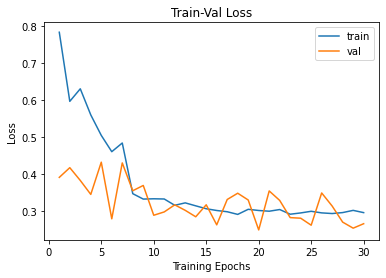

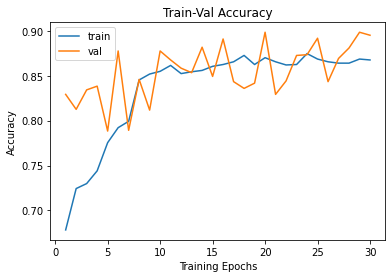

In [11]:
plot_loss(loss_history, metric_history)

In [17]:
test_loss, test_acc, preds, gr_th = test(model, loss_func, test_dl)

100%|██████████| 165/165 [00:03<00:00, 51.77it/s]

Testing Phase --- Loss: 0.2028 Acc: 92.8788


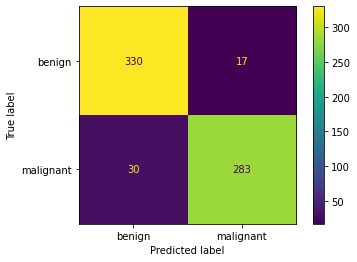

In [18]:
labels = ["benign", "malignant"]
cm = confusion_matrix(preds, gr_th)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [21]:
torch.save(model.state_dict(), "final.pth")

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testing_model = get_model()
testing_model = testing_model.to(device)

weights = torch.load("final.pth")
testing_model.load_state_dict(weights)

loss_func = nn.CrossEntropyLoss()

test_loss, test_acc, preds, gr_th = test(testing_model, loss_func, test_dl)

100%|██████████| 165/165 [00:04<00:00, 37.74it/s]

Testing Phase --- Loss: 0.2028 Acc: 92.8788


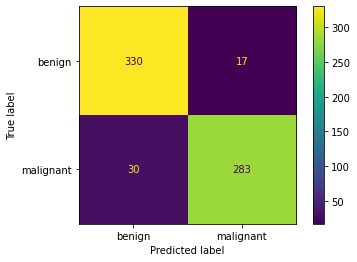

In [9]:
labels = ["benign", "malignant"]
cm = confusion_matrix(preds, gr_th)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()